# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

As the demand for professionals among different industries is rising, getting a reasonable compensation for the work you do at a company is a need for every job seekers. However, salary that ones get tend to vary from many factors such as experiences, education, previous job title, etc. Knowing your value in the market allows more room for salary negotiation. This project is to build a model that predict salary that can be deployed in business or as individual use. 

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# My information
__author__ = " Cho_Hang"
__email__ = "joench1993@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
!ls -lh data/

total 269304
-rwxr-xr-x@ 1 ngjo  staff    56M Oct  8  2016 test_features.csv
-rwxr-xr-x@ 1 ngjo  staff    56M Oct  8  2016 train_features.csv
-rwxr-xr-x@ 1 ngjo  staff    20M Oct  8  2016 train_salaries.csv


In [3]:
train_fea = pd.read_csv('data/train_features.csv')
train_salary = pd.read_csv('data/train_salaries.csv')

In [4]:
train_fea.shape

(1000000, 8)

In [5]:
train_salary.shape

(1000000, 2)

### ---- 3 Inspect and clean the data ----

In [6]:
train_fea.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

In [7]:
train_salary.isnull().any()

jobId     False
salary    False
dtype: bool

In [8]:
train_fea.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object

In [9]:
train_salary.dtypes

jobId     object
salary     int64
dtype: object

In [10]:
# Merging the dataset train_salary and train_fea
train_merged = pd.merge(train_fea,train_salary, how='left', on='jobId')

In [11]:
# Look for duplicated values.
train_merged.duplicated().any()

False

After some preprocessing and dataset, the merged training dataset looks clean.

### ---- 4 Explore the data (EDA) ----

In [12]:
train_merged.shape

(1000000, 9)

In [13]:
train_merged.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [14]:
#inspect the new merged dataset
train_merged.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [15]:
# Check if every record are unique
train_merged.jobId.nunique() == len(train_merged)

True

(array([5.00000e+00, 2.44700e+03, 1.88630e+04, 4.66860e+04, 8.13050e+04,
        1.18643e+05, 1.46773e+05, 1.53004e+05, 1.37725e+05, 1.08907e+05,
        7.73940e+04, 5.02090e+04, 2.93930e+04, 1.58530e+04, 7.58900e+03,
        3.41800e+03, 1.27000e+03, 3.87000e+02, 1.09000e+02, 2.00000e+01]),
 array([  0.  ,  15.05,  30.1 ,  45.15,  60.2 ,  75.25,  90.3 , 105.35,
        120.4 , 135.45, 150.5 , 165.55, 180.6 , 195.65, 210.7 , 225.75,
        240.8 , 255.85, 270.9 , 285.95, 301.  ]),
 <a list of 20 Patch objects>)

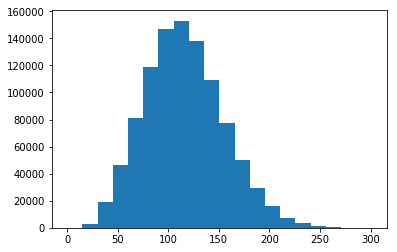

In [16]:
# Check the distribution of the target variable. 
plt.hist(train_merged['salary'],20)

In [17]:
# Draw 10% sample from the original dataset for fasting training and ensure a more normally distributed target variable
train_subset = train_merged.sample(n=100000,replace = True)

Text(0.5, 1.0, 'Histogram of salary')

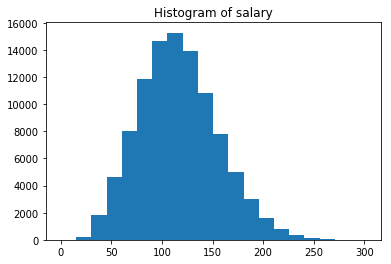

In [18]:
# Salary distribution from the subset
plt.hist(train_subset['salary'],20)
plt.title('Histogram of salary')

In [19]:
jobtype_group = train_subset.groupby('jobType')
jobtype_group.mean()

,yearsExperience,milesFromMetropolis,salary
jobType,,,
CEO,12.033501,49.666694,145.358188
CFO,12.195690,49.547965,135.685634
CTO,12.004067,49.677087,135.636175
JANITOR,12.020124,48.986477,71.434195
JUNIOR,11.824479,49.431094,94.869617
MANAGER,12.053191,49.125439,115.583457
SENIOR,12.067881,49.518169,106.033575
VICE_PRESIDENT,12.073080,49.105489,125.393915


In [20]:
degree_group = train_subset.groupby('degree')
degree_group.mean()

,yearsExperience,milesFromMetropolis,salary
degree,,,
BACHELORS,11.946895,49.321083,125.075783
DOCTORAL,12.062711,49.482717,135.744913
HIGH_SCHOOL,12.032521,49.419943,102.297842
MASTERS,12.140005,49.379511,130.844553
NONE,11.999873,49.312178,98.427061


In [21]:
industry_group = train_subset.groupby('industry')
industry_group.mean()

,yearsExperience,milesFromMetropolis,salary
industry,,,
AUTO,11.978476,49.622258,109.366115
EDUCATION,11.973651,49.474142,99.807638
FINANCE,12.042030,49.097273,131.421282
HEALTH,12.030228,49.419955,115.370722
OIL,12.104676,49.390270,131.334808
SERVICE,12.116513,49.258144,104.942377
WEB,11.993392,49.399559,121.791374


In [22]:
major_group = train_subset.groupby('major')
major_group.mean()

,yearsExperience,milesFromMetropolis,salary
major,,,
BIOLOGY,11.916781,48.997937,127.787483
BUSINESS,12.098712,49.663711,135.050192
CHEMISTRY,11.957846,49.413627,129.441500
COMPSCI,12.090755,49.688018,132.135373
ENGINEERING,12.061008,49.464538,138.110588
LITERATURE,12.153202,49.239453,124.478565
MATH,12.048463,49.071044,133.531353
NONE,12.027020,49.380907,102.819606
PHYSICS,12.005780,49.490479,130.789697


,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,-0.002536,0.381264
milesFromMetropolis,-0.002536,1.000000,-0.296853
salary,0.381264,-0.296853,1.000000


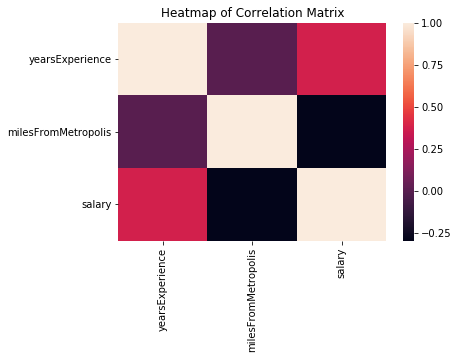

In [23]:
#look for correlation between each feature and the target
corr = train_subset.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

Text(0, 0.5, 'Count')

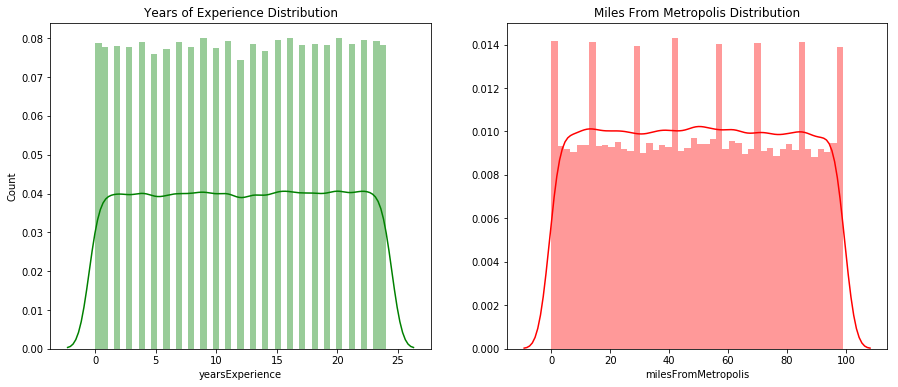

In [24]:
# Check distribution for years of experience
f, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.distplot(train_subset.yearsExperience, color="g", ax=axes[0]).set_title('Years of Experience Distribution')
axes[0].set_ylabel('Count')

sns.distplot(train_subset.milesFromMetropolis, color="r", ax=axes[1]).set_title('Miles From Metropolis Distribution')
axes[0].set_ylabel('Count')


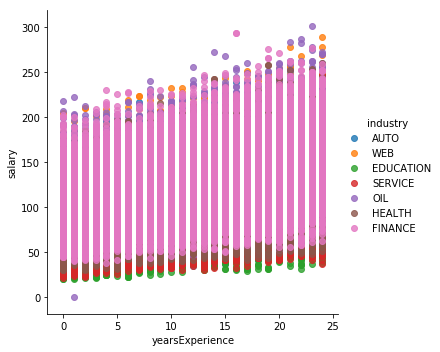

In [25]:
sns.lmplot(x='yearsExperience', y='salary', data=train_subset,
           fit_reg=False, # No regression line
           hue='industry')   

In [26]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for jobType in train_subset.jobType:
        if train_subset['jobType'].dtype == object:
            train_subset['jobType'] = le.fit_transform(train_subset['jobType'])
        else:
            pass
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for degree in train_subset.degree:
        if train_subset['degree'].dtype == object:
            train_subset['degree'] = le.fit_transform(train_subset['degree'])
        else:
            pass
        
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for major in train_subset.major:
        if train_subset['major'].dtype == object:
            train_subset['major'] = le.fit_transform(train_subset['major'])
        else:
            pass
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for industry in train_subset.industry:
        if train_subset['industry'].dtype == object:
            train_subset['industry'] = le.fit_transform(train_subset['industry'])
        else:
            pass


### ---- 5 Establish a baseline ----

In [27]:
# The following script divides data into attributes and labels:
X = train_subset.drop(['jobId','companyId','salary'],axis=1)
y = train_subset['salary']

In [28]:
# Split into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

In [29]:
# Training the Algorithm
model_1 = RandomForestRegressor(n_jobs = -1,oob_score=True, random_state=40)

In [30]:
# Fiting data
model_1.fit(X_train,y_train)

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=True, random_state=40, verbose=0, warm_start=False)

In [31]:
# Prediction
y_pred = model_1.predict(X_test) 
y_pred

array([ 29.4       , 168.4       ,  58.55      , ...,  77.3       ,
       107.5       ,  95.23333333])

In [32]:
# Mean square error will be used to define my model performance
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

Mean Squared Error: 439.12753850034494


### ---- 6 Hypothesize solution ----

The mean square error for the baseline model is 450, I am planning to tune the model and find the optimize depth_tree,n_estimators, and min_leaf.
The other solution to improve the error is to employ gradient boosting, and neural network. 


Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

jobType                0.370650
degree                 0.039470
major                  0.084023
industry               0.098382
yearsExperience        0.197743
milesFromMetropolis    0.209732
dtype: float64


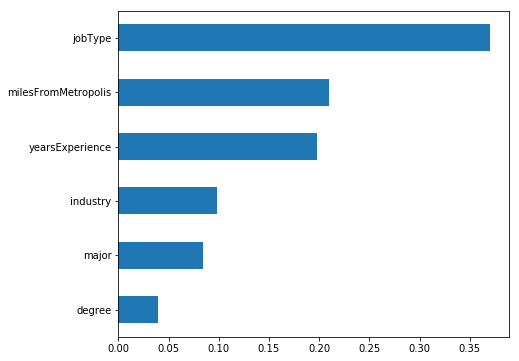

In [ ]:
#Using random forest regressor to check the feature importance.
feature_importances = pd.Series(model_1.feature_importances_, index=X.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

### ---- 8 Create models ---- Tuning Random Forest

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 depth
MSE Train:  290.0596012942571
MSE Test:  765.3006308874716
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 depth
MSE Train:  136.99929909859262
MSE Test:  524.5678278310028
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 depth
MSE Train:  105.38609373838946
MSE Test:  474.22537783642497
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


10 depth
MSE Train:  83.1969645113712
MSE Test:  439.15068138780845
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


20 depth
MSE Train:  72.12668682260323
MSE Test:  420.95213974187476
 
50 depth
MSE Train:  65.43860277644222
MSE Test:  409.05569020303443
 
100 depth
MSE Train:  63.16534160301051
MSE Test:  406.02763230304487
 


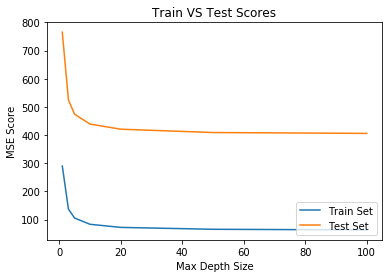

In [99]:
# Tuning max_depth_size
results  = []
results2 = []
max_depth_size  = [1,3,5,10,20]

for depth in max_depth_size:
    model = RandomForestRegressor(depth,n_jobs =-1 ,oob_score=True, random_state=44)
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(depth, 'depth')
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)
    mse1 = mean_squared_error(y_train, pred)
    mse2 = mean_squared_error(y_test, pred2)
    print('MSE Train: ', mse1)
    print('MSE Test: ', mse2)
    results.append(mse1)
    results2.append(mse2)
    print (" ")

plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('MSE Score')
plt.title('Train VS Test Scores')
plt.legend(loc="lower right")
plt.show()

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 trees
AUC:  -5.518124279118683
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 trees
AUC:  -1.8787358320622425
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 trees
AUC:  -0.3877149963177051
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


15 trees
AUC:  0.6650540185405462
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


20 trees
AUC:  0.6903114242339755
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


25 trees
AUC:  0.700445040545979
 
40 trees
AUC:  0.7118417955612654
 
50 trees
AUC:  0.7154619110466904
 
70 trees
AUC:  0.7194212393407072
 
100 trees
AUC:  0.7224841036392273
 


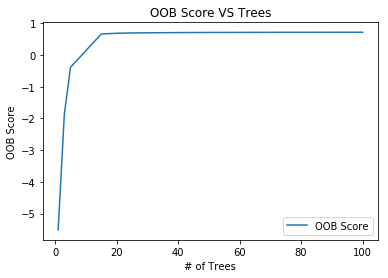

In [ ]:
results = []
n_estimator_options = [1, 3, 5, 15, 20, 25, 40, 50, 70, 100]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, random_state=42)
    #model.fit(X, y)
    model.fit(X_train, y_train)
    print(trees, 'trees')
    AUC = model.oob_score_
    print('AUC: ', AUC)
    results.append(AUC)
    print (" ")
    
plt.plot(n_estimator_options, results, label='OOB Score')
plt.xlabel('# of Trees')
plt.ylabel('OOB Score')
plt.title('OOB Score VS Trees')
plt.legend(loc="lower right")
plt.show()

/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


1 min samples
AUC:  0.700445040545979
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


2 min samples
AUC:  0.7138822359210297
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


3 min samples
AUC:  0.7213861711913796
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


4 min samples
AUC:  0.7258810930938469
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


5 min samples
AUC:  0.7287558569360184
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


6 min samples
AUC:  0.7300133298106255
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


7 min samples
AUC:  0.7310835762283184
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


8 min samples
AUC:  0.7317365266753485
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


9 min samples
AUC:  0.7318883302081589
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


10 min samples
AUC:  0.7318622397135597
 
20 min samples
AUC:  0.7288860278014577
 


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


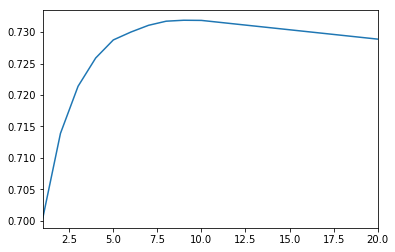

In [ ]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,20]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=25, oob_score=True, n_jobs=-1, random_state=42, max_features="auto", min_samples_leaf=min_samples)
    model.fit(X_train, y_train)
    print(min_samples, "min samples")
    auc = model.oob_score_
    print('AUC: ', auc)
    results.append(auc)
    print (" ")
    
pd.Series(results, min_samples_leaf_options).plot()

In [33]:
model_2 = RandomForestRegressor(n_jobs = -1,oob_score=True, random_state=40,n_estimators=25, max_depth=25,min_samples_leaf =10)
model_2.fit(X_train,y_train)
y_pred = model_2.predict(X_test) 
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

Mean Squared Error: 394.24518934315677


/Users/ngjo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


### ----8 Gradient Boosting ----

In [93]:
gbrt = GradientBoostingRegressor(max_depth=5, n_estimators=100,learning_rate=0.2)
gbrt.fit(X_train,y_train)
# Prediction
y_pred_2 = gbrt.predict(X_test) 
y_pred_2

array([ 29.3068729 , 144.02036987,  53.77933779, ...,  66.64914154,
       113.90832745,  98.87141954])

In [94]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_2))

Mean Squared Error: 359.87066987450754


In [81]:
for max_depth in [2,3,4,5,10]:
    clf = GradientBoostingRegressor(max_depth=max_depth)
    clf.fit(X_train, y_train)
    results.append(
        {
            'max_depth': max_depth,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })
    
# Display Results
max_depth_lr = pd.DataFrame(results).set_index('max_depth').sort_index()
max_depth_lr

,test_error,train_error
max_depth,,
2,413.245737,421.984385
3,383.047978,386.267229
4,367.109187,365.618512
5,361.671292,352.743201
10,373.970579,212.453850


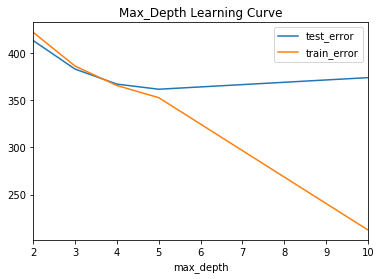

In [82]:
max_depth_lr.plot(title="Max_Depth Learning Curve")

In [88]:
results_learning=[]
for rate in [0.1,0.15,0.2,0.25,0.3]:
    clf = GradientBoostingRegressor(learning_rate=rate)
    clf.fit(X_train, y_train)
    results_learning.append(
        {
            'learning_rate': rate,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })
    
# Display Results
learning_rate_lr = pd.DataFrame(results_learning).set_index('learning_rate').sort_index()
learning_rate_lr

,test_error,train_error
learning_rate,,
0.10,383.047978,386.267229
0.15,369.849422,370.478372
0.20,369.234975,369.156012
0.25,368.971198,367.381338
0.30,367.519184,365.747516


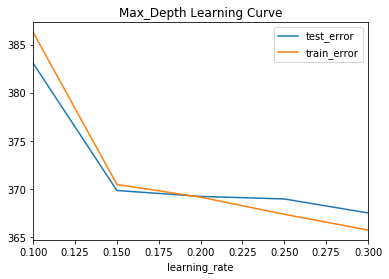

In [90]:
learning_rate_lr.plot(title="Max_Depth Learning Curve")

### ---- 9 Test models ----

In [1]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#Gradient Boosting so far gives me the best mean square error with less than 360. 

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data